In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import sys, os
import seaborn as sns
sys.path.insert(0, os.path.abspath('/home/qdeng/Github/cvxbook_additional_exercises/python'))

In [2]:
cp.version.full_version

'1.5.2'

## Problem 1 -- Completed

In [3]:
from seasonal_shading_data import *

In [4]:
T = s.shape[0]
n = 365 # Periodicity
omega = 300 # hyperparameter
T

1095

In [5]:
gamma = cp.Variable(T)

obj = (
    -1 * cp.sum(
        [cp.log(gamma[t])+gamma[t]*np.log(s[t]) for t in range(T)]
    )
    + omega * cp.sum(
        [cp.square(gamma[t+1]-gamma[t]) for t in range(n)]
    )
    + omega * cp.square(gamma[365]-gamma[0])
)

obj

Expression(CONVEX, UNKNOWN, ())

In [6]:
constraints = []
constraints += [gamma[t] == gamma[t+n] for t in range(T-n)]

In [7]:
prob = cp.Problem(
    cp.Minimize(obj),
    constraints
)
prob.solve()

/home/qdeng/.pyenv/versions/3.12.1/envs/cvx/lib/python3.12/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


np.float64(-4.579298006620498)

Text(0, 0.5, 'gamma')

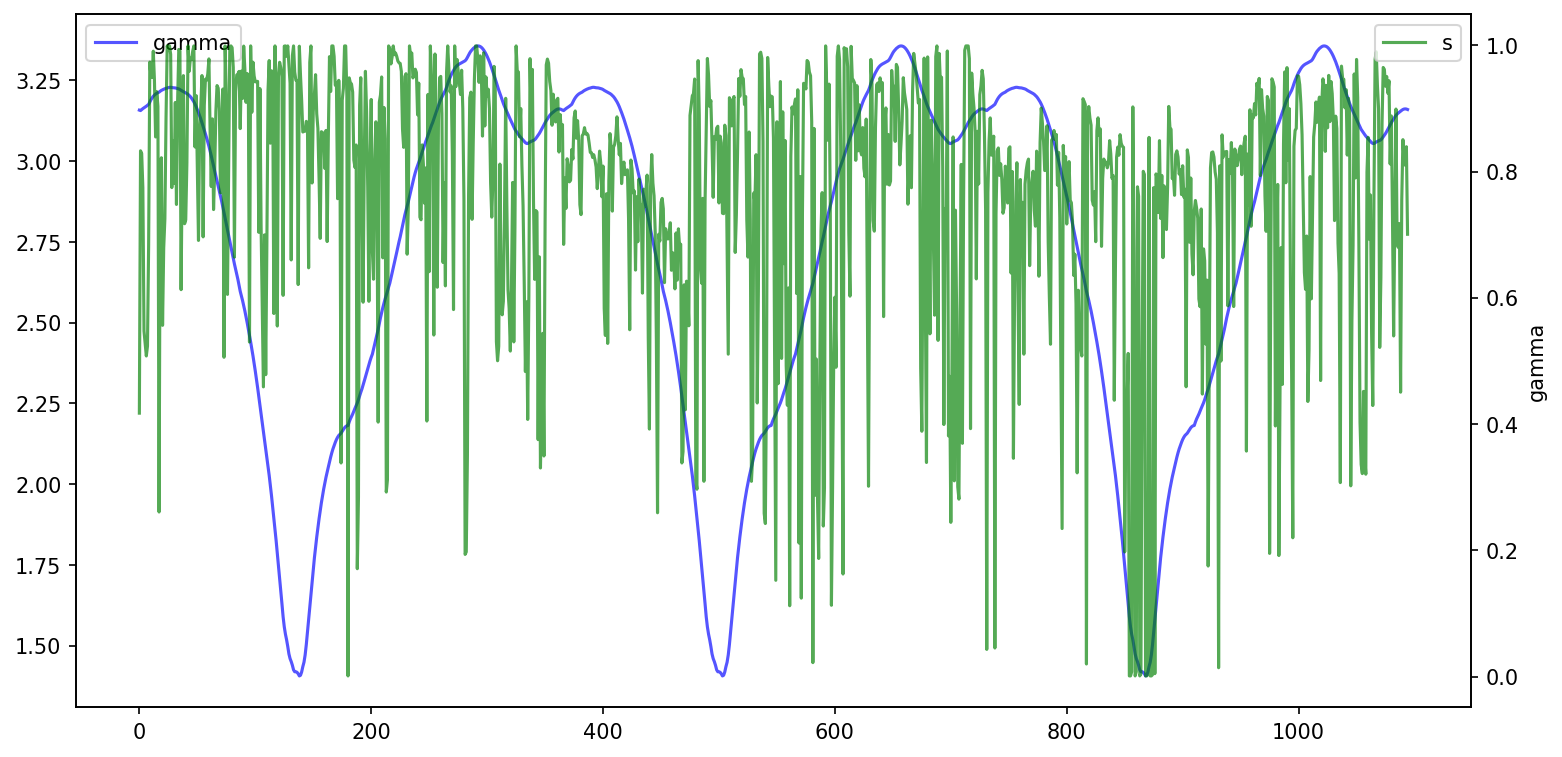

In [8]:
fig, ax = plt.subplots(figsize=(12,6), dpi=150)
ax.plot(range(T),gamma.value,'b',label='gamma',alpha=2/3)


ax2 = ax.twinx()
ax2.plot(range(T),s,'g',label='s',alpha=2/3)
ax2.set_ylabel('s')

ax.legend(loc=2)
ax2.legend(loc=1)
ax2.set_ylabel('gamma')
# ax.grid()

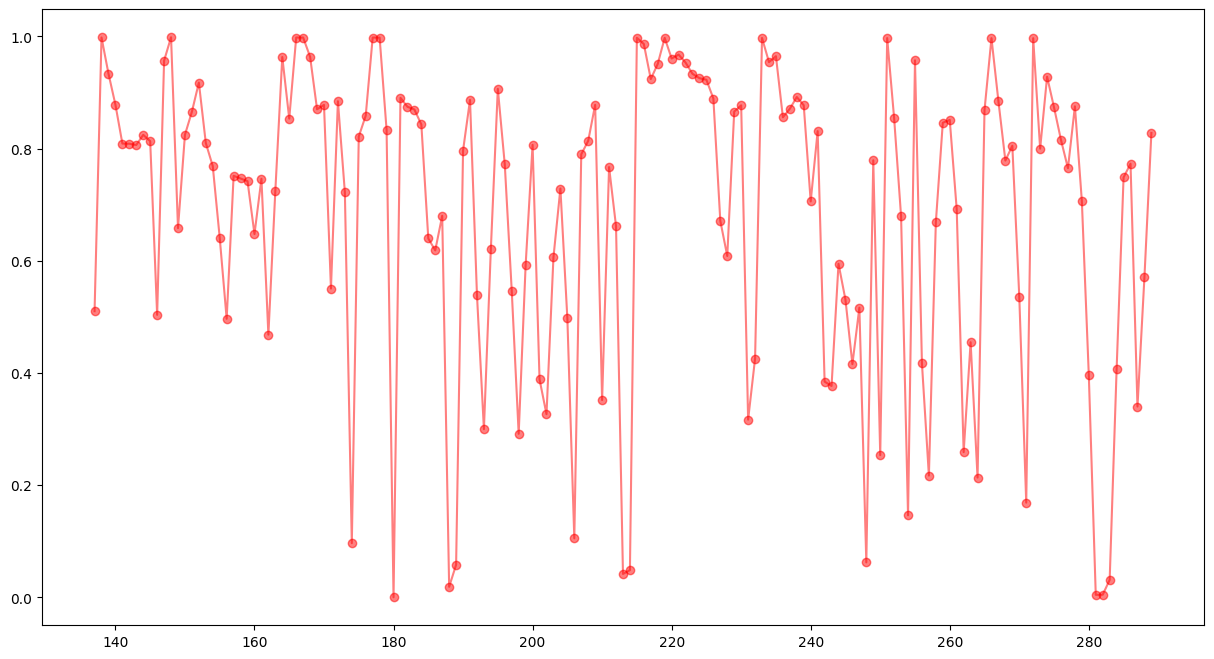

In [9]:
T_plt = np.arange(138-1, 290, 1) # Zero indexing in Python and 1-indexing in Problem 
T_plt

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(T_plt,
        [s[t]**gamma.value[t] for t in T_plt],
         'ro-',label='gamma',alpha=1/2)

(array([ 5.,  4.,  1.,  1.,  1.,  1.,  2.,  2.,  1.,  3.,  2.,  4.,  4.,
         1.,  3.,  4.,  4.,  3.,  4.,  5.,  5.,  5.,  6.,  8., 15.,  8.,
        20.,  6., 11., 14.]),
 array([2.84897304e-07, 3.32782113e-02, 6.65561377e-02, 9.98340640e-02,
        1.33111990e-01, 1.66389917e-01, 1.99667843e-01, 2.32945770e-01,
        2.66223696e-01, 2.99501622e-01, 3.32779549e-01, 3.66057475e-01,
        3.99335401e-01, 4.32613328e-01, 4.65891254e-01, 4.99169181e-01,
        5.32447107e-01, 5.65725033e-01, 5.99002960e-01, 6.32280886e-01,
        6.65558813e-01, 6.98836739e-01, 7.32114665e-01, 7.65392592e-01,
        7.98670518e-01, 8.31948444e-01, 8.65226371e-01, 8.98504297e-01,
        9.31782224e-01, 9.65060150e-01, 9.98338076e-01]),
 <BarContainer object of 30 artists>)

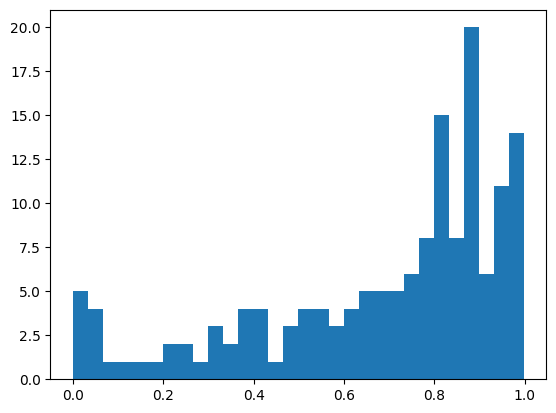

In [10]:
fig, ax = plt.subplots()

ax.hist([s[t]**gamma.value[t] for t in T_plt],bins=30)

**Comments:**
- the optimal objective value of the problem is -4.579
- Over the course of three years, we observe higher gamma around the summer months (around July), and lower around winter month (around December, that is July + ~150 day)
- The variation in gamma following the pattern in s with periodicity constraints. While the first year did not see a low shade fraction in the winter months, the drop in winter months for the second and third years have a significant impact on our estimation of gamma and result in low gamma, which correponds to our interpretation that a lower gamma means the shading factor is getting more likely than higher shade factors.

## Problem 2 -- Completed

In [3]:
from smooth_ride_plot import *

In [4]:
T = 301  # Total time periods (in seconds)
K = 5  # Number of green lights
L = 3000  # Total length of the route (in meters)
g = [10,50,100,200,240]# Time green light turns on
r = [40,80,130,230,270]# Time green light turns off
l = [300,825,1620,1900,2800]# Positions of the lights (in meters)
S_min = 4.0  # Minimum speed (m/s)
S_max = 16.0  # Maximum speed (m/s)

In [5]:
p = cp.Variable(T)
s = cp.Variable(T-1)
a = cp.Variable(T-2)
j = cp.Variable(T-3)

# obj = 1/(T-2)*cp.sum_squares(j)
obj = 1/(T-2)*cp.sum([cp.square(j_i) for j_i in j])

obj

Expression(CONVEX, NONNEGATIVE, ())

In [6]:
constraints = []
constraints += [j[t]==a[t+1]-a[t] for t in range(T-3)]
constraints += [a[t]==s[t+1]-s[t] for t in range(T-2)]
constraints += [s[t]==p[t+1]-p[t] for t in range(T-1)]
constraints += [p[0]==0]
constraints += [p[-1]==L]
constraints += [s[0]==0]
constraints += [s[i+1]-S_min>=0 for i in range(T-2)]
constraints += [s-S_max<=0]

# Red Light constraints
for k in range(K):
    constraints += [
        p[t]>=l[k] for t in np.arange(r[k], T)
    ]

# Green Light constraints
for k in range(K):
    constraints += [
        p[t]<=l[k] for t in np.arange(0,g[k])
    ]

In [7]:
prob = cp.Problem(
    cp.Minimize(obj),
    constraints
)
prob.solve('CLARABEL')

np.float64(0.0069189503127390925)

In [8]:
prob.is_dcp()

True

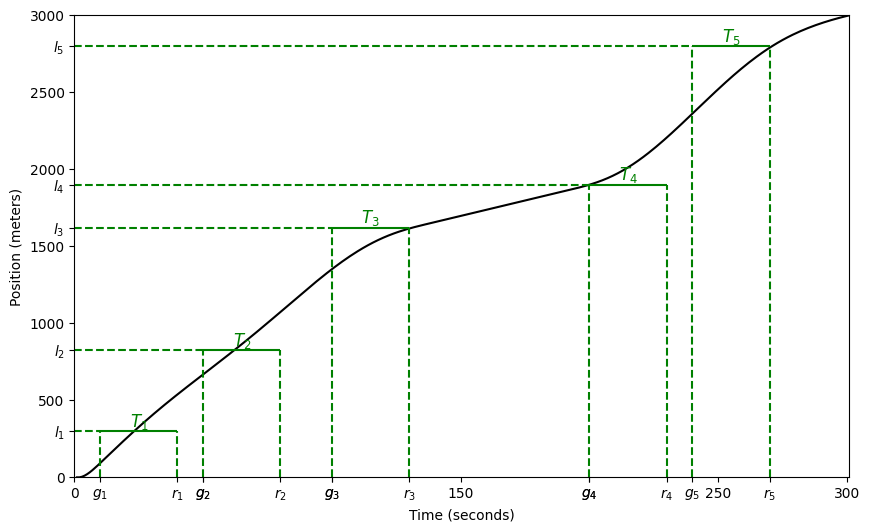

In [9]:
plot_trajectory(p.value, l, g, r)

**Comment:**
- Compare to the piecewise linear trajectory shown in the problem prompt which violates Maximum Speed and ignore the jerkiness of the ride, the optimal trajectory that minimizes the jerk looks very much like a smoothened version of it -- in the sense that, while we cross Light 1 and 2 in the middle of the green, we really waited until the last possible second to cross Light 3 and 5, and crossed Light 4 at the earliest possible instant.

## Problem 3 -- Completed

In [3]:
from cccv_charging_plot import *

In [4]:
Q_max = 6300 
Q_min = 960 
R = 0.4
a = 3.4
b = 500
Q_crit = 6925
I_max = 1.5 
V_max = 4.22 
E = 20975
T_fast = 120
T_normal = 180
T_slow = 240
h = 60

In [5]:
results = []

for T in [T_fast, T_normal, T_slow]:
    i = cp.Variable(T)
    q = cp.Variable(T+1)
    
    v_oc = cp.Variable(T)
    v = cp.Variable(T)
    
    obj = h*R*cp.sum([cp.square(i_i) for i_i in i])
    
    constraints = []
    constraints += [q[0]==Q_min]
    constraints += [q[-1]==Q_max]
    constraints += [q[t+1] == q[t] + h*i[t] for t in range(T)]
    constraints += [v[t] == v_oc[t] + R*i[t] for t in range(T)]
    constraints += [v - V_max<=0]
    constraints += [i - I_max<=0]
    constraints += [i >= 0]
    constraints += [v_oc[t] >= a + b * cp.inv_pos(Q_crit-q[t]) for t in range(T)] #??? make this DCP
    
    prob = cp.Problem(
        cp.Minimize(obj),
        constraints
    )
    
    prob.solve()

    results.append(i.value)
    results.append(v.value)
    results.append(q.value)

/home/qdeng/.pyenv/versions/3.12.1/envs/cvx/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [6]:
constraints[0].dual_value

0.3036175337862522

In [7]:
cp.inv_pos(Q_crit-q[0])

Expression(CONVEX, NONNEGATIVE, ())

In [8]:
len(results)

9

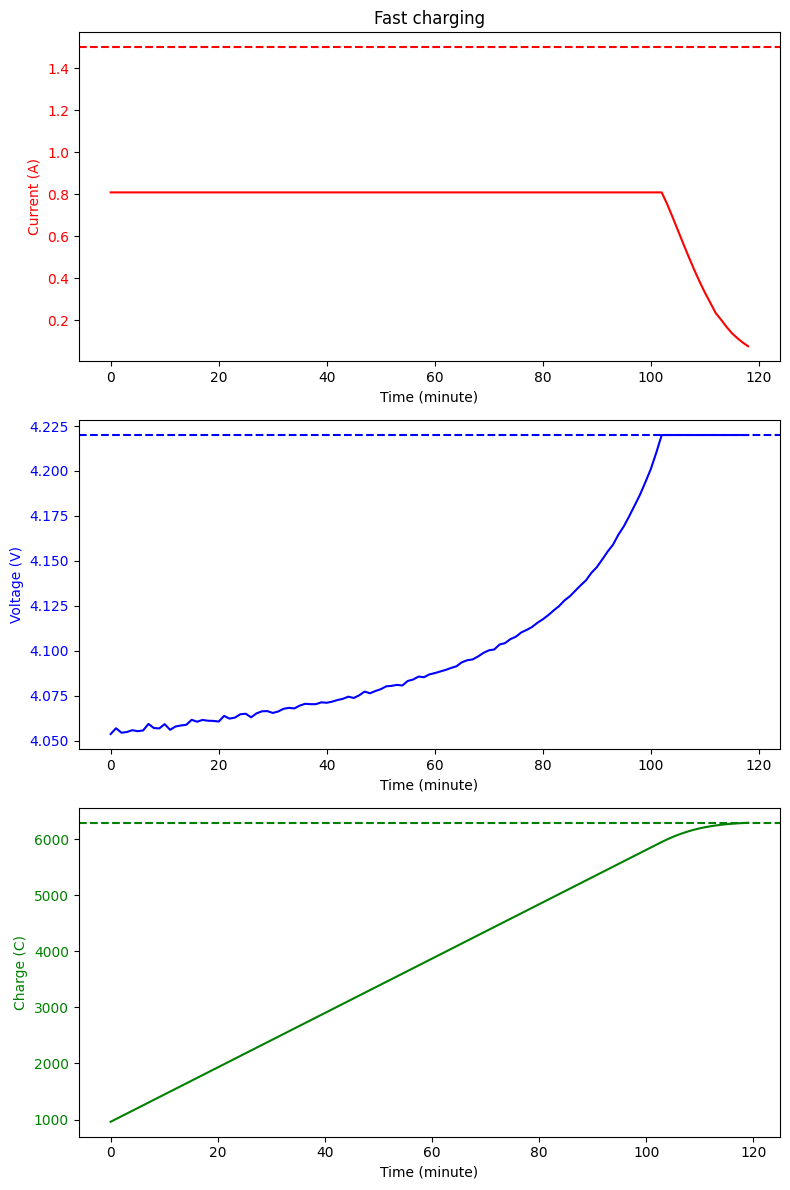

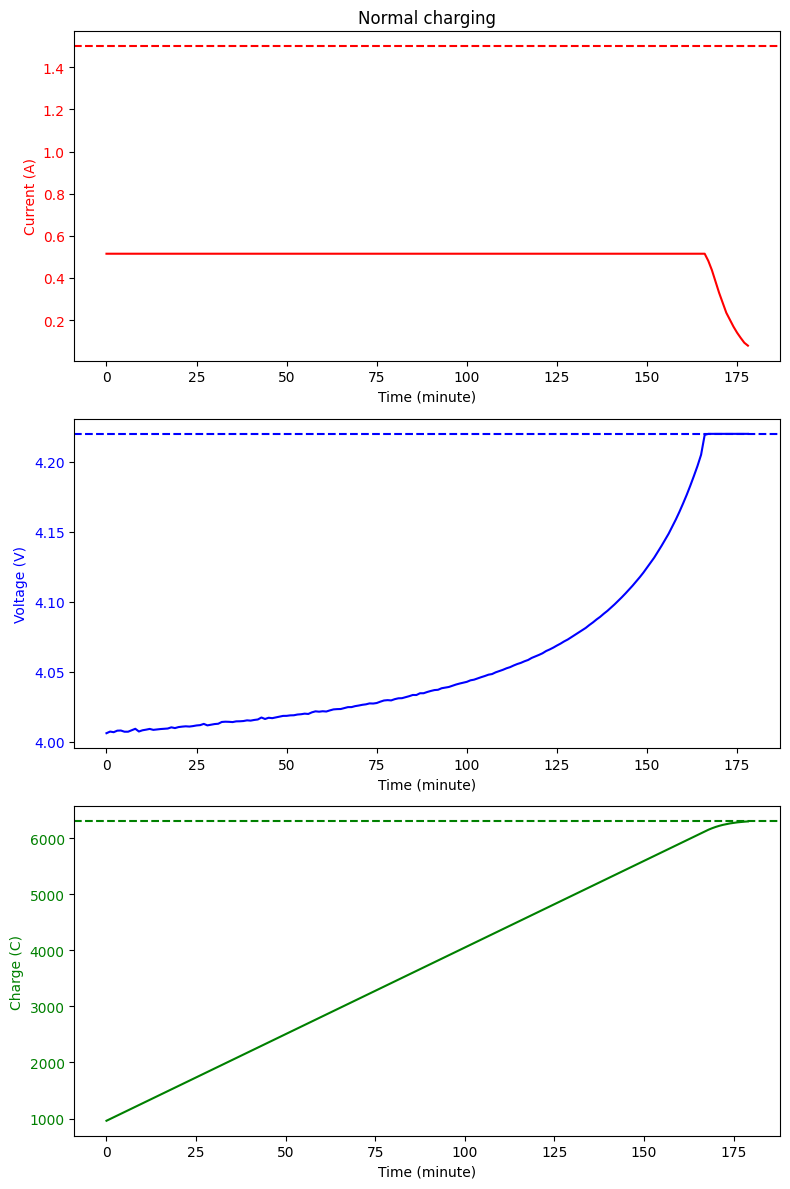

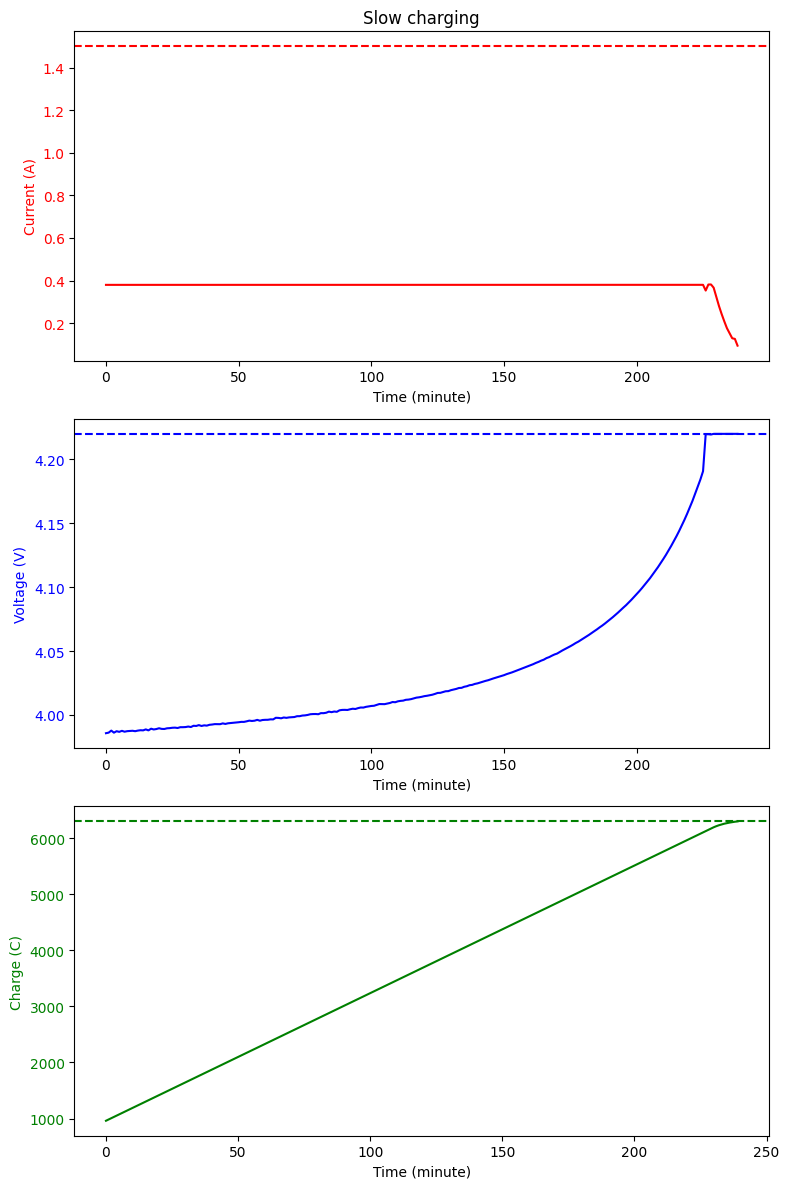

In [9]:
#Fast charging
# i_fast = i.value#np.zeros((T_fast,))
# v_fast = v.value#np.zeros((T_fast,))
# q_fast = q.value#np.zeros((T_fast,))
# #Normal charging
# i_normal = np.zeros((T_normal,))
# v_normal = np.zeros((T_normal,))
# q_normal = np.zeros((T_normal,))
# #Slow charging
# i_slow = np.zeros((T_slow,))
# v_slow = np.zeros((T_slow,))
# q_slow = np.zeros((T_slow,))
i_fast, v_fast, q_fast, i_normal, v_normal, q_normal, i_slow, v_slow, q_slow = results
#Example usage
plot_charging(i_fast, v_fast, q_fast, i_normal, v_normal, q_normal, i_slow, v_slow, q_slow, I_max, V_max, Q_max)

**Part (c) Comment:**
- The industry Standard CCCV charging is exactly what the solved optimal charging strategy is above. Across all three charging speed, we see a charging profile that consists of a constant current charging for the first majority amount of charging and switching to constant voltage but variable current charging once the maximum allowed voltage has been reached.

## Problem 4 -- Completed

In [3]:
from cond_gauss_reg_data import *

In [4]:
T, n = x.shape
x.shape, y.shape

((1000, 10), (1000,))

In [5]:
omega = cp.Variable(T)
kappa = cp.Variable(T)
alpha = cp.Variable(n)
beta = cp.Variable(n)
u = cp.Variable()
v = cp.Variable()

In [6]:
omega == alpha@x.T+u

Equality(Variable((np.int32(1000),), var1), Expression(AFFINE, UNKNOWN, (np.int32(1000),)))

In [7]:
kappa == beta@x.T+v

Equality(Variable((np.int32(1000),), var2), Expression(AFFINE, UNKNOWN, (np.int32(1000),)))

In [8]:
cp.log(omega)-1/2*(cp.multiply(y, omega)-kappa)

Expression(CONCAVE, UNKNOWN, (np.int32(1000),))

In [9]:
cp.multiply(y, omega)

Expression(AFFINE, UNKNOWN, (np.int32(1000),))

In [10]:
cp.square(cp.multiply(y, omega)-kappa)

Expression(CONVEX, NONNEGATIVE, (np.int32(1000),))

In [11]:
obj = cp.sum(
    cp.log(omega)-1/2*cp.square(cp.multiply(y, omega)-kappa)
)
obj

Expression(CONCAVE, UNKNOWN, ())

In [12]:
constraints = []
constraints += [omega == alpha@x.T+u]
constraints += [kappa == beta@x.T+v]
constraints += [-cp.norm2(alpha)+u>=0]
constraints += [cp.norm_inf(alpha)<=1]
# constraints += [alpha@x[i,:]+u>=0 for i in range(T)]
# constraints += [omega>=0]

In [16]:
prob = cp.Problem(
    cp.Maximize(obj),
    constraints
)
prob.solve()

np.float64(400.59972701237064)

In [17]:
sigma = 1/omega.value
mu = np.multiply(omega.value, kappa.value)

In [18]:
print('Distribution Mean of y1 given x1: %.2f'%mu[0]**2)
print('Distribution Variance of y1 given x1: %.2f'%sigma[0]**2)

Distribution Mean of y1 given x1: 1.51
Distribution Variance of y1 given x1: 0.16


## Problem 5 -- Completed

In [3]:
n = 5
lamb = 10
C = cp.Variable((n,n))

Cg = np.array(
[
    [1, -0.5, 0, 0, 0.7],
    [-0.5, 1, 0, -0.6, 0.8],
    [0, 0, 1, 0.3, 0],
    [0, -0.6, 0.3, 1, 0],
    [0.7, 0.8, 0, 0, 1],
]
)


Cg==Cg.T

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [4]:
Cg!=0

array([[ True,  True, False, False,  True],
       [ True,  True, False,  True,  True],
       [False, False,  True,  True, False],
       [False,  True,  True,  True, False],
       [ True,  True, False, False,  True]])

In [5]:
Cg[Cg!=0]

array([ 1. , -0.5,  0.7, -0.5,  1. , -0.6,  0.8,  1. ,  0.3, -0.6,  0.3,
        1. ,  0.7,  0.8,  1. ])

In [6]:
obj = -cp.log_det(C) + lamb*cp.norm1(cp.hstack([C[Cg!=0]-Cg[Cg!=0]]))
obj

Expression(CONVEX, UNKNOWN, ())

In [7]:
constraints = []
constraints += [C>>0]
constraints += [C[i,i]==1 for i in range(n)]

In [8]:
prob = cp.Problem(
    cp.Minimize(obj), 
    constraints
)
prob.solve()

np.float64(14.152968271939406)

In [9]:
constraints[0].dual_value

array([[ 1.65250690e-15,  0.00000000e+00, -1.46062354e-16,
         1.16849883e-15,  7.78999222e-16],
       [ 0.00000000e+00,  1.65250690e-15, -3.89499611e-16,
        -3.89499611e-16,  1.16849883e-15],
       [-1.46062354e-16, -3.89499611e-16,  6.05919196e-15,
         1.94749805e-15, -2.28831021e-15],
       [ 1.16849883e-15, -3.89499611e-16,  1.94749805e-15,
        -5.50835632e-16, -7.78999222e-16],
       [ 7.78999222e-16,  1.16849883e-15, -2.28831021e-15,
        -7.78999222e-16,  2.75417816e-15]])

In [10]:
np.round(C.value, 2)

array([[ 1.  , -0.48,  0.09,  0.29,  0.48],
       [-0.48,  1.  , -0.18, -0.6 ,  0.48],
       [ 0.09, -0.18,  1.  ,  0.3 , -0.09],
       [ 0.29, -0.6 ,  0.3 ,  1.  , -0.29],
       [ 0.48,  0.48, -0.09, -0.29,  1.  ]])

In [11]:
Cg

array([[ 1. , -0.5,  0. ,  0. ,  0.7],
       [-0.5,  1. ,  0. , -0.6,  0.8],
       [ 0. ,  0. ,  1. ,  0.3,  0. ],
       [ 0. , -0.6,  0.3,  1. ,  0. ],
       [ 0.7,  0.8,  0. ,  0. ,  1. ]])

**Comment**
- 6 of the off diagonal entries from $C_g$ were modified
    1. Cg(1,2) = -0.5 -> C(1,2) = -0.48
    2. Cg(2,1) = -0.5 -> C(2,1) = -0.48
    3. Cg(1,5) = 0.7 -> C(1,5) = 0.48
    2. Cg(5,1) = 0.7 -> C(5,1) = 0.48
    3. Cg(2,5) = 0.8 -> C(2,5) = 0.48
    2. Cg(5,2) = 0.8 -> C(5,2) = 0.48


## Problem 6 -- Completed

In [3]:
T = 20
n = 3
m = 4

x0 = np.array([0,0,0])
xT = np.array([1, 2, -1])

A = np.array([
    [1, 0.1, 0],
    [0, 9,-0.1],
    [-0.1, 0, 0.9]
])

B = np.array(
    [
        [0.9, -0.4, 0, 0.6],
        [2.0, 0.7, 0.2, -0.4],
        [0.0, 0.2, -0.3, 1.7]
    ]
)

list_bin = []
for i in range(2**m):
    bin_index = f'{i:04b}'
    list_bin.append(bin_index)
    
bool_index = [[True if digit=='1' else False for digit in num] for num in list_bin]

list_B = []
for i_list in bool_index:
    print(i_list)
    B_i = B.copy()
    B_i[:, i_list] = 0

    list_B.append(B_i)

[False, False, False, False]
[False, False, False, True]
[False, False, True, False]
[False, False, True, True]
[False, True, False, False]
[False, True, False, True]
[False, True, True, False]
[False, True, True, True]
[True, False, False, False]
[True, False, False, True]
[True, False, True, False]
[True, False, True, True]
[True, True, False, False]
[True, True, False, True]
[True, True, True, False]
[True, True, True, True]


In [4]:
list_feasible = []
for Bi in list_B:
    x = cp.Variable((n,T))
    u = cp.Variable((m,T-1))
    
    obj = 0
    
    constraints = []
    constraints += [x[:,0]==x0]
    constraints += [x[:,-1]==xT]
    constraints += [cp.norm_inf(u[:, t])<=1 for t in range(T-1)]
    constraints += [x[:,t+1]==A@x[:,t]+Bi@u[:,t] for t in range(T-1)]
    
    prob = cp.Problem(
        cp.Minimize(obj),
        constraints
    )
    
    if prob.solve()==0:
        list_feasible.append(1)
    else:
        list_feasible.append(0)

In [5]:
list_feasible

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0]

In [6]:
np.array(list_feasible)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0])

In [7]:
np.sum(np.array(bool_index), axis=1)#[list_feasible]

array([0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4])

In [8]:
np.array(bool_index)[(np.array(list_feasible))&(np.sum(np.array(bool_index), axis=1)==3)==1,:]

array([[False,  True,  True,  True],
       [ True, False,  True,  True],
       [ True,  True,  True, False]])

Comment: 
- The minimum number of actuators need to achieve a trajectory is 1
- This can be achieved by
  1. Having only the first (0) actuator: $u_0$ used, $u_1$ $u_2$ $u_3$ unused
  2. Having only the second (1) actuator: $u_1$ used, $u_0$ $u_2$ $u_3$ unused
  3. Having only the fourth (3) actuator: $u_3$ used, $u_0$ $u_1$ $u_2$ unused

In [9]:
# Verification for only first actuator
x = cp.Variable((n,T))
u = cp.Variable((m,T-1))

obj = 0

constraints = []
constraints += [x[:,0]==x0]
constraints += [x[:,-1]==xT]
constraints += [cp.norm_inf(u[:, t])<=1 for t in range(T-1)]
constraints += [x[:,t+1]==A@x[:,t]+B@u[:,t] for t in range(T-1)]

constraints += [u[[1,2,3],:]==0]

prob = cp.Problem(
    cp.Minimize(obj),
    constraints
)

prob.solve()

0.0

In [10]:
# Verification for only second actuator
x = cp.Variable((n,T))
u = cp.Variable((m,T-1))

obj = 0

constraints = []
constraints += [x[:,0]==x0]
constraints += [x[:,-1]==xT]
constraints += [cp.norm_inf(u[:, t])<=1 for t in range(T-1)]
constraints += [x[:,t+1]==A@x[:,t]+B@u[:,t] for t in range(T-1)]

constraints += [u[[0,2,3],:]==0]

prob = cp.Problem(
    cp.Minimize(obj),
    constraints
)

prob.solve()

0.0

In [11]:
# Verification for only fourth actuator
x = cp.Variable((n,T))
u = cp.Variable((m,T-1))

obj = 0

constraints = []
constraints += [x[:,0]==x0]
constraints += [x[:,-1]==xT]
constraints += [cp.norm_inf(u[:, t])<=1 for t in range(T-1)]
constraints += [x[:,t+1]==A@x[:,t]+B@u[:,t] for t in range(T-1)]

constraints += [u[[0,1,2],:]==0]

prob = cp.Problem(
    cp.Minimize(obj),
    constraints
)

prob.solve()

0.0

## Problem 7 --Attempt 1

In [3]:
A = np.array(
    [
        [0.2, -0.2, 0.6, -0.6] ,
        [-0.2, 0.4, -1.4, 1.3],
        [0.6, -1.4, 5.2, -4.7],
        [-0.6, 1.3, -4.7, 4.4]
    ]
)

n, _ = A.shape

I = np.eye(n)



In [4]:
beta = 0.5
D = cp.Variable((n,n))

obj = 0

constraints = []
constraints += [D[i,j]==0 for i in range (n) for j in range(n) if i!=j]
constraints += [D-I>>0]
constraints += [cp.lambda_max(D)-beta*cp.lambda_min(D)<=0]

prob = cp.Problem(
    cp.Minimize(obj),
    constraints
)

prob.solve()

inf

In [5]:
A

array([[ 0.2, -0.2,  0.6, -0.6],
       [-0.2,  0.4, -1.4,  1.3],
       [ 0.6, -1.4,  5.2, -4.7],
       [-0.6,  1.3, -4.7,  4.4]])

In [6]:
U, S, Vh = np.linalg.svd(A)
# U==Vh.T
U.T

array([[-0.088678  ,  0.19660857, -0.71878621,  0.6609294 ],
       [ 0.84455772, -0.1993116 , -0.41296455, -0.27650935],
       [-0.47078505,  0.09100114, -0.54757315, -0.6857433 ],
       [ 0.23920682,  0.95568758,  0.11388731, -0.12833952]])

In [7]:
A_half = np.diag(np.sqrt(S))@U.T
A_half.T@A_half

array([[ 0.2, -0.2,  0.6, -0.6],
       [-0.2,  0.4, -1.4,  1.3],
       [ 0.6, -1.4,  5.2, -4.7],
       [-0.6,  1.3, -4.7,  4.4]])

In [8]:
cp.square(cp.norm(A_half@D))

Expression(CONVEX, NONNEGATIVE, ())

In [9]:
cp.square(cp.norm(A_half@cp.inv_pos(D)))

Expression(UNKNOWN, NONNEGATIVE, ())

In [10]:
lambda_A_max = max(S)
lambda_A_min = min(S)

In [30]:
u = 1000
l = 0

while (u-l)>1e-6:
    beta = (u+l)/2
    # print(beta)
    D = cp.Variable((n,n))

    obj = 0

    constraints = []
    constraints += [D[i,j]==0 for i in range (n) for j in range(n) if i!=j]
    constraints += [D-I>>0]
    constraints += [cp.lambda_max(A@D)-beta*cp.lambda_min(A@D)<=0]
    # constraints += [cp.lambda_max(D@A@D)-beta*cp.lambda_min(D@A@D)<=0] ### CVXPY does not accept Matrix Quad Form
    # constraints += [(cp.square(cp.norm(A_half@D))-beta<=0)]

    
    prob = cp.Problem(
        cp.Minimize(obj),
        constraints
    )
    
    val = prob.solve()

    if val==np.inf:
        l = beta
    else:
        u = beta
    

# Do a final solve with u such that we report a feasible D
beta = u
D = cp.Variable((n,n))

obj = 0

constraints = []
constraints += [D[i,j]==0 for i in range (n) for j in range(n) if i!=j]
constraints += [D-I>>0]
constraints += [cp.lambda_max(A@D)-beta*cp.lambda_min(A@D)<=0]
# obj = 0

# constraints = []
# constraints += [D[i,j]==0 for i in range (n) for j in range(n) if i!=j]
# constraints += [D-I>>0]
# # constraints += [Y==A@D]
# # constraints += [M[i,j] >= A[i,j]*cp.geo_mean(D[i,i], D[j,j]) for i in range (n) for j in range(n)]
# # constraints += [cp.lambda_max(D@A@D)-beta *cp.lambda_min(D@A@D)<=0]
# # constraints += [cp.square(cp.lambda_max(D))-beta *cp.square(cp.lambda_min(D))<=0]
# constraints += [(cp.square(cp.norm(A_half@D))-beta<=0)]

prob = cp.Problem(
    cp.Minimize(obj),
    constraints
)
prob.solve()

0.0

In [31]:
cp.square(cp.max(D))#-beta *cp.square(cp.norm_inf(-D))

Expression(UNKNOWN, NONNEGATIVE, ())

In [32]:
A@cp.square(D)@A

Expression(UNKNOWN, UNKNOWN, (np.int32(4), np.int32(4)))

In [33]:
u, l, beta

(224.08816777169704, 224.08816684037447, 224.08816777169704)

In [35]:
eigval_A = np.linalg.eigvals(A)
cond_A = np.max(eigval_A) / np.min(eigval_A)
cond_A

np.float64(1170.1104124302037)

In [36]:
eigval_DAD = np.linalg.eigvals(D.value@A@D.value)
cond_DAD = np.max(eigval_DAD) / np.min(eigval_DAD)
cond_DAD

np.float64(1170.1082748362933)

In [37]:
D.value

array([[ 9.99954321e-01,  5.14407986e-08, -3.03613969e-09,
         2.37509480e-10],
       [ 1.29185768e-07,  9.99953084e-01,  1.94706254e-08,
        -2.14011441e-08],
       [-9.56315948e-08,  8.87066798e-08,  9.99952288e-01,
         1.42542573e-08],
       [ 1.04730558e-07, -9.52184333e-08,  1.35969837e-08,
         9.99952297e-01]])

## Problem 7 --Attempt 2

In [ ]:
d

In [133]:
A = np.array(
    [
        [0.2, -0.2, 0.6, -0.6] ,
        [-0.2, 0.4, -1.4, 1.3],
        [0.6, -1.4, 5.2, -4.7],
        [-0.6, 1.3, -4.7, 4.4]
    ]
)

n, _ = A.shape

I = np.eye(n)



In [157]:
d = cp.Variable(n)

i = 0
j = 1
d[i]*A[i,j]*d[j]

Expression(UNKNOWN, UNKNOWN, ())

In [150]:
beta = 10000
D = cp.Variable((n,n))

obj = 0

constraints = []
constraints += [D[i,j]==0 for i in range (n) for j in range(n) if i!=j]
constraints += [D>>I]
# constraints += [beta >= 0]
constraints += [A.T@D@A >= D]
constraints += [beta*D >= A.T@D@A ]

prob = cp.Problem(
    cp.Minimize(obj),
    constraints
)

prob.solve()

inf

In [151]:
constraints

[Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ())),
 Equality(Expression(AFFINE, UNKNOWN, ()), Constant(CONSTANT, ZERO, ())),
 PSD(Expression(AFFINE, UNKNOWN, (np.int32(4), np.int32(4)))),
 Inequality(Variable((np.int32(4), np.int32(4)), 

## Problem 8 -- Completed

In [3]:
sigma = np.array(
    [
        [4.9, -3.8, 1.4],
        [-3.8, 3.8, -1.9],
        [1.4, -1.9, 2.5]
    ]
)

n = 3

sigma==sigma.T

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [4]:
np.linalg.svd(sigma)

SVDResult(U=array([[-0.69882028, -0.46563551,  0.54298599],
       [ 0.63207126, -0.04660389,  0.7735076 ],
       [-0.33486734,  0.88374863,  0.32688257]]), S=array([9.00790176, 1.86255367, 0.32954456]), Vh=array([[-0.69882028,  0.63207126, -0.33486734],
       [-0.46563551, -0.04660389,  0.88374863],
       [ 0.54298599,  0.7735076 ,  0.32688257]]))

In [9]:
lamb = cp.Variable((2*n, 2*n))
delta = cp.Variable(n)

In [10]:
obj = cp.sum(
    cp.hstack(
        [lamb[i,n+i] for i in range(n)]
    )
)

In [11]:
constraints = []
constraints += [lamb[:n,-n:]==sigma+cp.diag(delta)]
constraints += [lamb[-n:,:n]==sigma+cp.diag(delta)]
constraints += [lamb[:n,:n]==sigma]
constraints += [lamb[-n:,-n:]==sigma]
constraints += [lamb>>0]
# constraints += [W@lambda == W@lambda]

In [12]:
prob = cp.Problem(
    cp.Minimize(obj),
    constraints
)

prob.solve()

np.float64(7.899909909236449)

In [13]:
np.round(lamb.value,2)

array([[ 4.9, -3.8,  1.4,  3.7, -3.8,  1.4],
       [-3.8,  3.8, -1.9, -3.8,  3.8, -1.9],
       [ 1.4, -1.9,  2.5,  1.4, -1.9,  0.4],
       [ 3.7, -3.8,  1.4,  4.9, -3.8,  1.4],
       [-3.8,  3.8, -1.9, -3.8,  3.8, -1.9],
       [ 1.4, -1.9,  0.4,  1.4, -1.9,  2.5]])

In [14]:
for i in range(n):
    print(f'lambda[{i},{i+n}] %.2f'%lamb.value[i, i+n])

lambda[0,3] 3.70
lambda[1,4] 3.80
lambda[2,5] 0.40
